In [2]:
import json
import os.path as op
import os
import torch 
import tqdm
import pandas as pd
import scipy.stats as st
from scipy.spatial import distance
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader, Data
import h5py
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.io.trajectory import Trajectory
import ase
import argparse

# custom functions
from utils.data import test_dataloader, dataloader
from utils.models import load_model
#from utils.infer import infer, infer_with_error
from utils.model_to_ase import SchnetCalculator
from ttm.ase import TTMCalculator

from utils.water_dataset import PrepackedDataset


def roundto(x, base=5):
    return base * round(x/base)

### modified torch_cluster.knn
https://pytorch-geometric.readthedocs.io/en/1.3.0/_modules/torch_cluster/knn.html

In [3]:
import torch
import scipy.spatial

# can't use knn_cuda bc I don't know how to edit it
#if torch.cuda.is_available():
#    import torch_cluster.knn_cuda


def knn(x, y, k, batch_x=None, batch_y=None, boxsize=None):
    r"""Finds for each element in :obj:`y` the :obj:`k` nearest points in
    :obj:`x`.

    Args:
        x (Tensor): Node feature matrix
            :math:`\mathbf{X} \in \mathbb{R}^{N \times F}`.
        y (Tensor): Node feature matrix
            :math:`\mathbf{X} \in \mathbb{R}^{M \times F}`.
        k (int): The number of neighbors.
        batch_x (LongTensor, optional): Batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns each
            node to a specific example. (default: :obj:`None`)
        batch_y (LongTensor, optional): Batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^M`, which assigns each
            node to a specific example. (default: :obj:`None`)
        boxsize (array_like or scalar, optional): Apply a m-d toroidal topology 
            to the KDTree. The topology is generated by :math:`x_i + n_i L_i`
            where n_i are integers and L_i is the boxsize along i-th dimension. 
            The input data shall be wrapped into [0,L_i). A ValueError is raised 
            if any of the data is outside of this bound.
            # x and y scaling means box size should be 1.0000001

    :rtype: :class:`LongTensor`

    .. testsetup::

        import torch
        from torch_cluster import knn

    .. testcode::

        >>> x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
        >>> batch_x = torch.tensor([0, 0, 0, 0])
        >>> y = torch.Tensor([[-1, 0], [1, 0]])
        >>> batch_x = torch.tensor([0, 0])
        >>> assign_index = knn(x, y, 2, batch_x, batch_y)
    """

    if batch_x is None:
        batch_x = x.new_zeros(x.size(0), dtype=torch.long)

    if batch_y is None:
        batch_y = y.new_zeros(y.size(0), dtype=torch.long)

    x = x.view(-1, 1) if x.dim() == 1 else x
    y = y.view(-1, 1) if y.dim() == 1 else y

    assert x.dim() == 2 and batch_x.dim() == 1
    assert y.dim() == 2 and batch_y.dim() == 1
    assert x.size(1) == y.size(1)
    assert x.size(0) == batch_x.size(0)
    assert y.size(0) == batch_y.size(0)

    #if x.is_cuda:
    #    return torch_cluster.knn_cuda.knn(x, y, k, batch_x, batch_y)

    # Rescale x and y.
    min_xy = min(x.min().item(), y.min().item())
    x, y = x - min_xy, y - min_xy

    max_xy = max(x.max().item(), y.max().item())
    x, y, = x / max_xy, y / max_xy
    
    # Concat batch/features to ensure no cross-links between examples exist.
    x = torch.cat([x, 2 * x.size(1) * batch_x.view(-1, 1).to(x.dtype)], dim=-1)
    y = torch.cat([y, 2 * y.size(1) * batch_y.view(-1, 1).to(y.dtype)], dim=-1)

    # Note: added boxsize to cKDTree
    tree = scipy.spatial.cKDTree(x.detach().numpy(), boxsize=boxsize)
    dist, col = tree.query(
        y.detach().cpu(), k=k, distance_upper_bound=x.size(1))
    
    dist = torch.from_numpy(dist).to(x.dtype)
    col = torch.from_numpy(col).to(torch.long)
    row = torch.arange(col.size(0), dtype=torch.long).view(-1, 1).repeat(1, k)
    
    #mask = 1 - torch.isinf(dist).view(-1)
    mask = ~torch.isinf(dist).view(-1)
    
    row, col = row.view(-1)[mask], col.view(-1)[mask]

    return torch.stack([row, col], dim=0)



def pbc_knn_graph(x, k, batch=None, loop=False, flow='source_to_target', boxsize=None):
    r"""Computes graph edges to the nearest :obj:`k` points.

    Args:
        x (Tensor): Node feature matrix
            :math:`\mathbf{X} \in \mathbb{R}^{N \times F}`.
        k (int): The number of neighbors.
        batch (LongTensor, optional): Batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns each
            node to a specific example. (default: :obj:`None`)
        loop (bool, optional): If :obj:`True`, the graph will contain
            self-loops. (default: :obj:`False`)
        flow (string, optional): The flow direction when using in combination
            with message passing (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)
        boxsize (array_like or scalar, optional): Apply a m-d toroidal topology 
            to the KDTree. The topology is generated by :math:`x_i + n_i L_i`
            where n_i are integers and L_i is the boxsize along i-th dimension. 
            The input data shall be wrapped into [0,L_i). A ValueError is raised 
            if any of the data is outside of this bound.
            
    :rtype: :class:`LongTensor`

    .. testsetup::

        import torch
        from torch_cluster import knn_graph

    .. testcode::

        >>> x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
        >>> batch = torch.tensor([0, 0, 0, 0])
        >>> edge_index = knn_graph(x, k=2, batch=batch, loop=False)
    """

    assert flow in ['source_to_target', 'target_to_source']
    row, col = knn(x, x, k if loop else k + 1, batch, batch, boxsize)
    row, col = (col, row) if flow == 'source_to_target' else (row, col)
    if not loop:
        mask = row != col
        row, col = row[mask], col[mask]
    return torch.stack([row, col], dim=0)

### modified utils/models.py

In [4]:
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_, zeros_
from torch_geometric.nn.models.schnet import GaussianSmearing, \
    InteractionBlock, ShiftedSoftplus
from torch_scatter.scatter import scatter_add
from torch_geometric.nn import radius_graph #, knn_graph
import sys
import logging

class SchNet(nn.Module):
    def __init__(self,
                 num_features: int = 100,
                 num_interactions: int = 4,
                 num_gaussians: int = 25,
                 cutoff: float = 6.0,
                 max_num_neighbors: int = 28,
                 neighbor_method: str = 'knn',
                 batch_size: Optional[int] = None,
                 mean: Optional[float] = None, 
                 std: Optional[float] = None,
                 boxsize = None):
        """
        :param num_features (int): The number of hidden features used by both
            the atomic embedding and the convolutional filters (default: 100).
        :param num_interactions (int): The number of interaction blocks
            (default: 4).
        :param num_gaussians (int): The number of gaussians used in the radial
            basis expansion (default: 25).
        :param cutoff (float): Cutoff distance for interatomic interactions
            which must match the one used to build the radius graphs
            (default: 6.0).
        :param max_num_neighbors (int): The maximum number of neighbors to
            collect for each node within the :attr:`cutoff` distance.
            (default: 28)
        :param neighbor_method (str): Method to collect neighbors for each node.
            'knn' uses knn_graph; 'radius' uses radius_graph. 
            (default: 'knn')
        :param batch_size (int, optional): The number of molecules in the batch.
            This can be inferred from the batch input when not supplied.
        :param mean (float, optional): The mean of the property to predict.
            (default: None)
        :param std (float, optional): The standard deviation of the property to
            predict. (default: None)
        :param boxsize (array_like or scalar, optional): Apply a m-d toroidal topology 
            to the KDTree. The topology is generated by :math:`x_i + n_i L_i`
            where n_i are integers and L_i is the boxsize along i-th dimension. 
            The input data shall be wrapped into [0,L_i). A ValueError is raised 
            if any of the data is outside of this bound.
        """
        super().__init__()
        self.num_features = num_features
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        self.max_num_neighbors = max_num_neighbors
        self.neighbor_method = neighbor_method
        self.batch_size = batch_size
        self.mean = mean
        self.std = std
        self.boxsize=boxsize
        if boxsize != None:
            self.box = 1.0000001
        else:
            self.box = None

        self.atom_embedding = nn.Embedding(100,
                                           self.num_features,
                                           padding_idx=0)
        self.basis_expansion = GaussianSmearing(0.0, self.cutoff,
                                                self.num_gaussians)

        self.interactions = nn.ModuleList()

        for _ in range(self.num_interactions):
            block = InteractionBlock(self.num_features, self.num_gaussians,
                                     self.num_features, self.cutoff)
            self.interactions.append(block)

        self.lin1 = nn.Linear(self.num_features, self.num_features // 2)
        self.act = ShiftedSoftplus()
        self.lin2 = nn.Linear(self.num_features // 2, 1)

        self.reset_parameters()

    def hyperparameters(self):
        """
        hyperparameters for the SchNet model.
        :returns: Dictionary of hyperparamters.
        """
        return {
            "num_features": self.num_features,
            "num_interactions": self.num_interactions,
            "num_gaussians": self.num_gaussians,
            "cutoff": self.cutoff,
            "batch_size": self.batch_size
        }

    def extra_repr(self) -> str:
        """
        extra representation for the SchNet model.
        :returns: comma-separated string of the model hyperparameters.
        """
        s = []
        for key, value in self.hyperparameters().items():
            s.append(f"{key}={value}")

        return ", ".join(s)

    def reset_parameters(self):
        """
        Initialize learnable parameters used in training the SchNet model.
        """
        self.atom_embedding.reset_parameters()

        for interaction in self.interactions:
            interaction.reset_parameters()

        xavier_uniform_(self.lin1.weight)
        zeros_(self.lin1.bias)
        xavier_uniform_(self.lin2.weight)
        zeros_(self.lin2.bias)

    def forward(self, data):
        """
        Forward pass of the SchNet model
        :param z: Tensor containing the atomic numbers for each atom in the
            batch. Vector with size [num_atoms].
        :param edge_weight: Tensor containing the interatomic distances for each
            interacting pair of atoms in the batch. Vector with size [num_edges]
        :param edge_index: Tensor containing the indices defining the
            interacting pairs of atoms in the batch. Matrix with size
            [2, num_edges]
        :param batch: Tensor assigning each atom within a batch to a molecule.
            This is used to perform per-molecule aggregation to calculate the
            predicted energy. Vector with size [num_atoms]
        :param energy_target (optional): Tensor containing the energy target to
            use for evaluating the mean-squared-error loss when training.
        """
        # Collapse any leading batching dimensions
        pos = data.pos

        """TODO: replace knn_graph with PBC cKDTree version"""
        if self.neighbor_method == 'knn':
            edge_index = pbc_knn_graph(
                data.pos,
                self.max_num_neighbors,
                data.batch,
                loop=False,
                boxsize=self.box
            )
        elif self.neighbor_method == 'radius':
            edge_index = radius_graph(data.pos, r=self.cutoff, batch=data.batch,
                                      max_num_neighbors=self.max_num_neighbors)

        else:
            raise ValueError(f"neighbor_method == {self.neighbor_method} not implemented; choose 'knn' or 'radius'")

        row, col = edge_index

        
        # TODO: apply PBC
        if self.boxsize==None:
            edge_weight = torch.norm(pos[col] - pos[row], p=2, dim=-1).view(-1, 1)
            
        else:    
            # MIC Described in:
            # W. Smith, "The Minimum Image Convention in Non-Cubic MD Cells", 1989,
            # http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.57.1696.
            dist_vec = pos[col] - pos[row]
            n_atoms = dist_vec.size()[1]

            # reshape distance vector (N_b*N_at, N_nbh, 3)
            dist_vec = dist_vec.reshape(-1, dist_vec.shape[-2], 3)

            cell = torch.tensor([[self.boxsize,0,0],[0,self.boxsize,0],[0,0,self.boxsize]])

            # tile and reshape cell to get (N_b*N_at, 3, 3)
            cell = cell.unsqueeze(1).repeat(1,n_atoms,1,1).reshape(-1,3,3)

            f = torch.transpose(torch.linalg.solve(torch.transpose(cell,1,2), 
                                                   torch.transpose(dist_vec,1,2)),1,2)
            f = torch.subtract(f, torch.floor(f + 0.5))

            distances = torch.linalg.norm(f @ cell, axis=-1).reshape(n_atoms,-1)
            edge_weight = distances[:1].view(-1, 1)
        
        edge_index = edge_index.view(2, -1).long()
        batch = data.batch.long()

        h = self.atom_embedding(data.z.long())
        edge_attr = self.basis_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        if self.mean is not None and self.std is not None:
            h = h * self.std + self.mean

        mask = (data.z == 0).view(-1, 1)
        h = h.masked_fill(mask.expand_as(h), 0.)

        batch = batch.view(-1)
        out = scatter_add(h, batch, dim=0, dim_size=self.batch_size).view(-1)

        return out

    @staticmethod
    def loss(input, target):
        """
        Calculates the mean squared error
        This loss assumes that zeros are used as padding on the target so that
        the count can be derived from the number of non-zero elements.
        """
        loss = F.mse_loss(input, target, reduction="sum")
        N = (target != 0.0).to(loss.dtype).sum()
        loss = loss / N
        return identity_loss(loss, reduction="none")
    
    
    


### modified utils/audit.py

In [23]:
import numpy as np
from ase.geometry.analysis import Analysis
import pandas as pd
from operator import itemgetter
import os.path as op
from scipy.stats import ks_2samp, wasserstein_distance
from utils import graph, models
import torch
import ase
from ase.calculators.calculator import Calculator, all_changes
from torch.nn import functional as F
from torch_geometric.data import Data


class PBCSchnetCalculator(Calculator):
    """ASE interface to trained model
    """
    implemented_properties = ['forces', 'energy']
    nolabel = True

    def __init__(self, best_model, atoms=None, boxsize=None, **kwargs):
        Calculator.__init__(self, **kwargs)
        
        state=torch.load(best_model)
    
        # remove module. from statedict keys (artifact of parallel gpu training)
        state = {k.replace('module.',''):v for k,v in state.items()}
        num_gaussians = state[f'basis_expansion.offset'].shape[0]
            
        num_filters = state[f'interactions.0.mlp.0.weight'].shape[0]
        num_interactions = len([key for key in state.keys() if '.lin.bias' in key])

        net = SchNet(num_features = num_filters,
                     num_interactions = num_interactions,
                     num_gaussians = num_gaussians,
                     cutoff = 6.0,
                     boxsize = boxsize,
                    )

        net.load_state_dict(state)

        self.net = net
        self.atoms = atoms

    def calculate(
        self, atoms=None, properties=None, system_changes=all_changes,
    ):
        if properties is None:
            properties = self.implemented_properties
        
        if atoms is not None:
            self.atoms = atoms.copy()
        
        Calculator.calculate(self, atoms, properties, system_changes)

        energy, gradients = schnet_eg(self.atoms, self.net)
        self.results['energy'] = energy
        self.results['forces'] = -gradients
        
def schnet_eg(atoms, net, device='cpu'):
    """
    Takes in ASE atoms and loaded net and predicts energy and gradients
    args: atoms (ASE atoms object), net (loaded trained Schnet model)
    return: predicted energy (eV), predicted gradients (eV/angstrom)
    """
    types = {'H': 0, 'O': 1}
    atom_types = [1, 8]
    
    #center = False
    #if center:
    #    pos = atoms.get_positions() - atoms.get_center_of_mass()
    #else:
    
    pos = atoms.get_positions()
    pos = torch.tensor(pos, dtype=torch.float) #coordinates
    size = int(pos.size(dim=0)/3)
    type_idx = [types.get(i) for i in atoms.get_chemical_symbols()]
    atomic_number = atoms.get_atomic_numbers()
    z = torch.tensor(atomic_number, dtype=torch.long)
    x = F.one_hot(torch.tensor(type_idx, dtype=torch.long),
                              num_classes=len(atom_types))
    data = Data(x=x, z=z, pos=pos, size=size, batch=torch.tensor(np.zeros(size*3), dtype=torch.int64), idx=1)

    data = data.to(device)
    data.pos.requires_grad = True
    e = net(data)
    f = torch.autograd.grad(e, data.pos, grad_outputs=torch.ones_like(e), retain_graph=True)[0].cpu().data.numpy()
    e = e.cpu().data.numpy()

    return e.item()/23.06035, f/23.06035

### test out code

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from operator import itemgetter
import os.path as op
from tqdm import tqdm
from multiprocessing import Pool

import ase
from ase.geometry.analysis import Analysis
from ase.db import connect
from ase.optimize.sciopt import SciPyFminBFGS, SciPyFminCG
from ase.io.trajectory import Trajectory

def flatten(l):
    return [item for sublist in l for item in sublist]

from utils import audit, graph, infer


# plot params
plt.rcParams.update({'legend.fontsize':14, 'font.size':16})
ticksize=14

In [7]:
best_model = '/qfs/projects/ecp_exalearn/designs/finetune_comparison/trained_models/finetune_ttm_alstep_023.pt'


datadir = '/qfs/projects/ecp_exalearn/designs/data/pbc'
trajfile = op.join(datadir, 'start_w256.xyz')
gt_energy = -2895.57 #kcal/mol
L = 19.7294

from ase.io import read
traj = read(trajfile,index=':')
print(len(traj))

n=0

1


In [8]:
forcefile = op.join(datadir, 'forces.xyz')

forces=[]
with open(forcefile, 'r') as f:
    fcs = f.readlines()

for f in fcs:
    forces.append([float(ii) for ii in f.replace('/n','').split(' ') if ii!=''])

gt_forces=np.array(forces)
gt_forces

array([[-11.19895913,  -3.74556538,   3.78869407],
       [  8.97092903,   6.62316954,  -5.70549012],
       [  1.95972145,  -1.52145109,   9.02522113],
       ...,
       [  5.50290354,   1.79895407,   8.22651877],
       [ -7.96930478,  10.78239052,   3.46443287],
       [ -1.88604701,  -1.33951449,  -0.44874246]])

In [9]:
atoms=traj[n]
atoms.pbc=[True,True,True]
atoms.cell=[L,L,L]

print(len(atoms))
print(f'mean distance with pbc {np.vstack([sorted(x)[1:] for x in atoms.get_all_distances(mic=True)]).mean()}')
print(f'mean distance with no pbc {np.vstack([sorted(x)[1:] for x in atoms.get_all_distances(mic=False)]).mean()}')

768
mean distance with pbc 9.485486852104936
mean distance with no pbc 13.030774489164823


In [10]:
# Code with PBC

atoms = traj[n]

calc = PBCSchnetCalculator(best_model, atoms, boxsize=L)
atoms.calc = calc
print(atoms.get_potential_energy())
print(atoms.get_forces())

-109.39716077189853
[[ 0.49851853  0.24900351 -0.28276956]
 [-0.77636296  0.04744468  0.22428909]
 [ 0.37942323 -0.3061203   0.29756355]
 ...
 [ 0.50387686 -0.7586476   0.329158  ]
 [-0.9465248   0.1556593  -0.30086875]
 [ 0.32831314  0.33322355 -0.00922439]]


In [11]:
# No PBC but using same code

atoms = traj[n]

calc = PBCSchnetCalculator(best_model, boxsize=None)
atoms.calc = calc
print(atoms.get_potential_energy())
print(atoms.get_forces())

-87.09178062602584
[[-6.3718610e-02 -5.7459958e-02 -4.2396497e-02]
 [-6.6985972e-02  1.1189625e-01 -3.6235765e-04]
 [ 7.2467878e-02 -1.1169036e-01  1.9000360e-01]
 ...
 [ 4.4794983e-01 -7.9143035e-01  2.4348614e-01]
 [-8.7401611e-01  1.6327623e-01 -2.5058505e-01]
 [ 3.1138259e-01  2.4232706e-01  1.4714297e-02]]


In [12]:
# Previous code w/out PBC (should be identical to above)

atoms = traj[n]
calc = audit.SchnetCalculator(best_model, atoms)
atoms.calc = calc
print(atoms.get_potential_energy())
print(atoms.get_forces())

-87.09178062602584
[[-6.3718639e-02 -5.7459958e-02 -4.2396501e-02]
 [-6.6985972e-02  1.1189625e-01 -3.6235765e-04]
 [ 7.2467878e-02 -1.1169036e-01  1.9000365e-01]
 ...
 [ 4.4794983e-01 -7.9143035e-01  2.4348614e-01]
 [-8.7401611e-01  1.6327623e-01 -2.5058505e-01]
 [ 3.1138253e-01  2.4232706e-01  1.4714300e-02]]


### comparison with and without PBC

In [13]:
# Code with PBC

atoms = traj[n].copy()

calc = PBCSchnetCalculator(best_model, atoms, boxsize=L)
atoms.calc = calc
energy_pbc=atoms.get_potential_energy()*23.0609
forces_pbc=atoms.get_forces()*23.0609

# No PBC but using same code

atoms = traj[n].copy()

calc = PBCSchnetCalculator(best_model, atoms, boxsize=None)
atoms.calc = calc
energy_nopbc=atoms.get_potential_energy()*23.0609
forces_nopbc=atoms.get_forces()*23.0609

In [14]:
print('comparison between NN with and without PBC')
print(f'energy dif {np.abs(energy_pbc-energy_nopbc):0.6f}')
print(f'fme {np.mean(np.abs(infer.force_magnitude_error(torch.from_numpy(forces_pbc), torch.from_numpy(forces_nopbc)).numpy())):0.6f}')
print(f'fae {np.mean(np.abs(infer.force_angular_error(torch.from_numpy(forces_pbc), torch.from_numpy(forces_nopbc)).numpy())):0.6f}')

comparison between NN with and without PBC
energy dif 514.382141
fme 5.825747
fae 0.160946


In [17]:
print('comparison between NN with PBC and TTM')
print(f'energy dif {np.abs(gt_energy-energy_pbc):0.6f}')
print(f'fme {np.mean(np.abs(infer.force_magnitude_error(torch.from_numpy(forces_pbc), torch.from_numpy(gt_forces)).numpy())):0.6f}')
print(f'fae {np.mean(np.abs(infer.force_angular_error(torch.from_numpy(forces_pbc).to(torch.float64), torch.from_numpy(gt_forces).to(torch.float64)).numpy())):0.6f}')

comparison between NN with PBC and TTM
energy dif 372.773015
fme 9.318416
fae 0.493048


In [18]:
print('comparison between NN without PBC and TTM')
print(f'energy dif {np.abs(gt_energy-energy_nopbc):0.6f}')
print(f'fme {np.mean(np.abs(infer.force_magnitude_error(torch.from_numpy(forces_nopbc), torch.from_numpy(gt_forces)).numpy())):0.6f}')
print(f'fae {np.mean(np.abs(infer.force_angular_error(torch.from_numpy(forces_nopbc).to(torch.float64), torch.from_numpy(gt_forces).to(torch.float64)).numpy())):0.6f}')

comparison between NN without PBC and TTM
energy dif 887.155156
fme 7.033294
fae 0.495201


In [19]:
traj = ase.io.read('/people/pope044/Exalearn/fast-finedtuned-forcefields/results/finetune_comparison-trained_models-finetune_ttm_alstep_023-nopbc/nnp1opt0.traj',index=':')
print(len(traj))

218


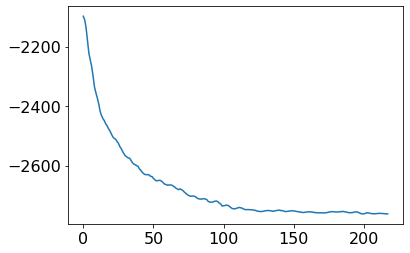

In [25]:
calc = TTMCalculator()

energies=[]
for atoms in traj:
    atoms.calc = calc
    energies.append(atoms.get_potential_energy())
    
plt.plot(energies)
plt.show()

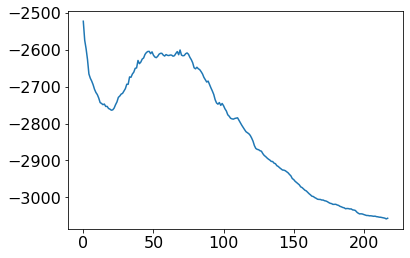

In [24]:
calc = PBCSchnetCalculator(best_model, boxsize=L)

energiesnnp=[]
for atoms in traj:
    atoms.calc = calc
    energiesnnp.append(atoms.get_potential_energy()*23.0609)
    
plt.plot(energiesnnp)
plt.show()

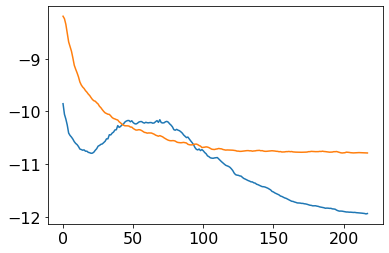

In [26]:
plt.plot([e/256 for e in energiesnnp])
plt.plot([e/256 for e in energies])
plt.show()

In [ ]:
calc = PBCSchnetCalculator(best_model, boxsize=None)

energiesnnp=[]
for atoms in traj:
    atoms.calc = calc
    energiesnnp.append(atoms.get_potential_energy()*23.0609)
    
plt.plot(energiesnnp)
plt.show()

In [ ]:
plt.plot(energiesnnp)
plt.plot(energies)
plt.show()